In [ ]:
# Issues
# 1. VAE is trainable, but the loss doesn't get lower enough.. Thus, the reconstruction shows poor result. I will Paul about this issue
# ... Solution 1) Use sub-pixel upsampling.
# ... Solution 2) This might be a problem: https://distill.pub/2016/deconv-checkerboard/
# ... Solution 3) Training more might will help
# ... Solution 4) Rescale output image, since it is normalized at the input stage (not sure)

# Idea
# 1. Data augmentation would be helpful in terms of feeding variety dataset.
# 2. We might want to try a stacked autoencoder

In [ ]:
import tensorflow as tf

import numpy as np
# these ones let us draw images in our notebook
import matplotlib.pyplot as plt

import pickle
import os
from tensorflow.python.framework import tensor_util
import math

#imports data
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
#############
# CIFAR 100 #
#############

cifar100_test = {}
cifar100_train = {}
# Load the raw CIFAR-100 data.
cifar100_test = unpickle('dataset/cifar-100-python/test')
cifar100_train = unpickle('dataset/cifar-100-python/train')

train_data = cifar100_train[b'data']
test_data = cifar100_test[b'data']

train_data = np.reshape(train_data,(50000, 3, 32, 32)).transpose(0,2,3,1).astype(float)
test_data = np.reshape(test_data,(10000, 3, 32, 32)).transpose(0,2,3,1).astype(float)

In [15]:
############
# CIFAR 10 #
############

cifar10_train = {}
cifar10_test  = {}
# Load the raw CIFAR-10 data.
cifar10_train = unpickle('dataset/cifar-10-python/data_batch_1')
train_data_1 = cifar10_train[b'data']
train_data_1 = np.reshape(train_data_1,(10000, 3, 32, 32)).transpose(0,2,3,1).astype(float)
cifar10_train = unpickle('dataset/cifar-10-python/data_batch_2')
train_data_2 = cifar10_train[b'data']
train_data_2 = np.reshape(train_data_2,(10000, 3, 32, 32)).transpose(0,2,3,1).astype(float)
cifar10_train = unpickle('dataset/cifar-10-python/data_batch_3')
train_data_3 = cifar10_train[b'data']
train_data_3 = np.reshape(train_data_3,(10000, 3, 32, 32)).transpose(0,2,3,1).astype(float)
cifar10_train = unpickle('dataset/cifar-10-python/data_batch_4')
train_data_4 = cifar10_train[b'data']
train_data_4 = np.reshape(train_data_4,(10000, 3, 32, 32)).transpose(0,2,3,1).astype(float)
cifar10_train = unpickle('dataset/cifar-10-python/data_batch_5')
train_data_5 = cifar10_train[b'data']
train_data_5 = np.reshape(train_data_5,(10000, 3, 32, 32)).transpose(0,2,3,1).astype(float)
cifar10_test  = unpickle('dataset/cifar-10-python/test_batch')
test_data  = cifar10_test[b'data']
test_data = np.reshape(test_data,(10000, 3, 32, 32)).transpose(0,2,3,1).astype(float)

train_data = []
train_data.append(train_data_1)
train_data.append(train_data_2)
train_data.append(train_data_3)
train_data.append(train_data_4)
train_data.append(train_data_5)

In [120]:
###########################
# This will go to util.py #
###########################

# Normalization: Input image should be normalized to have 0 mean and unit variation for the VAE.
train_data_normalized = train_data
for i in range(5):
    for j in range(10000):
        train_data_normalized[i][j] = train_data[i][j]-np.mean(train_data[i][j])
        train_data_normalized[i][j] = train_data_normalized[i][j]/np.std(train_data_normalized[i][j])

In [126]:
np.mean(train_data_normalized[0][9])
#train_data_normalized[0][1].shape

-1.8503717077085941e-17

In [417]:
######################
# Simple Autoencoder #
######################
# This one is for playing around to figure how does AE work. It won't be our model.

def upscale_block(x, f, scale=2):
    """ conv2d_transpose """
    x = tf.layers.conv2d_transpose(x, f, 3, strides=(scale, scale), padding='same', activation=tf.nn.relu)
    x = tf.nn.dropout(x, 0.5)
    return x

def downscale_block(x, f, scale=2):
    n, h, w, c = x.get_shape().as_list()
    conv = tf.layers.conv2d(x, f, 3, strides=1, padding='same')
    pool = tf.layers.max_pooling2d(conv, pool_size=(2,2), strides=scale, padding='same')
    return pool

def kl_divergence(p, q):
    """ inputs must be in (0, 1) """
    return p * tf.log(p/q) + (1-p) * tf.log((1-p)/(1-q))

def autoencoder_network(x, code_size=128):
    encoder_16 = downscale_block(x, 8)
    encoder_8 = downscale_block(encoder_16, 16)
    encoder_4 = downscale_block(encoder_8, 32)
    flatten_dim = np.prod(encoder_4.get_shape().as_list()[1:])
    flat = tf.reshape(encoder_4, [-1, flatten_dim])
    code = tf.layers.dense(flat, code_size, activation=tf.nn.relu)
    hidden_decoder = tf.layers.dense(code, flatten_dim, activation=tf.nn.elu)
    decoder_4 = tf.reshape(hidden_decoder, [-1,4,4,32])
    decoder_8 = upscale_block(decoder_4, 16)
    decoder_16 = upscale_block(decoder_8, 8)
    output = upscale_block(decoder_16, 3)
    return code, output

# set hyperparameters
sparsity_weight = 5e-3
code_size = 100

# define graph
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
code, outputs = autoencoder_network(x, code_size)

# just for fun
num_params = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
print('Parameters: ' + str(num_params))

# calculate loss
sparsity_loss = tf.norm(code, ord=1, axis=1)
reconstruction_loss = tf.reduce_mean(tf.square(outputs - x)) # MSE
total_loss = reconstruction_loss + sparsity_weight * sparsity_loss

# setup optimizer
optimizer = tf.train.AdamOptimizer(0.001)
train_op = optimizer.minimize(total_loss)

# train for an epoch and visualize
batch_size = 100
session = tf.Session()
session.run(tf.global_variables_initializer())
for epoch in range(1):
    # train batch (1 to 5)
    for k in range(5):
        print(k,"th training batch...")
        for i in range(train_data[k].shape[0] // batch_size):
            batch_xs = train_data[k][i*batch_size:(i+1)*batch_size, :]
            _,tl = session.run([train_op, total_loss], {x: batch_xs})
            if i%10 ==0:
                print("Total loss: ", np.average(tl))
print("Done!")
#### TESTING

Parameters: 115047
0 th training batch...
Total loss:  1.12137
Total loss:  0.999505
Total loss:  0.998327
Total loss:  0.999002
Total loss:  0.99895
Total loss:  0.998102
Total loss:  0.999796
Total loss:  0.997393
Total loss:  0.99755
Total loss:  0.998372
1 th training batch...
Total loss:  0.997023
Total loss:  0.998686
Total loss:  0.99659
Total loss:  0.999857
Total loss:  0.997359
Total loss:  0.996667
Total loss:  0.998451
Total loss:  0.997781
Total loss:  0.997063
Total loss:  1.00006
2 th training batch...
Total loss:  0.997341
Total loss:  0.996388
Total loss:  0.997841
Total loss:  0.99734
Total loss:  0.998688
Total loss:  0.999073
Total loss:  0.999902
Total loss:  0.99759
Total loss:  0.99946
Total loss:  0.998511
3 th training batch...
Total loss:  0.998217
Total loss:  0.998012
Total loss:  0.998896
Total loss:  0.996089
Total loss:  0.994283
Total loss:  0.994577
Total loss:  0.996127
Total loss:  0.993213
Total loss:  0.998179
Total loss:  0.997211
4 th training bat

Number of nonzero code dimensions: 1/100


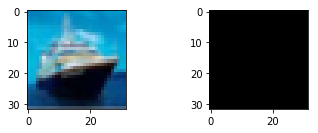

In [420]:
######################
# Simple Autoencoder #
######################
# Visualize result

idx = np.random.randint(test_data.shape[0])
x_out, code_out, output_out = session.run([x, code, outputs], {x: np.expand_dims(test_data[idx], axis=0)})
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(np.squeeze(x_out).astype("uint8"))
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(np.squeeze(output_out).astype("uint8"))

#print(code_out)
print("Number of nonzero code dimensions: {}/{}".format(np.count_nonzero(code_out), code_size))

In [443]:
################
# model of VAE #
################
# This will go to model.py 

def lrelu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))

def conv_block(inputs, filters, downscale=1):
    """
    Args:
        - inputs: 4D tensor of shape NHWC
        - filters: int
    """
    with tf.name_scope('conv_block') as scope:
        conv = tf.layers.conv2d(inputs, filters, 2, 1, padding='same', activation=tf.nn.elu)
        pool = tf.layers.max_pooling2d(conv, pool_size=(2,2), strides=downscale, padding='same')
        return pool

def gaussian_encoder(inputs, latent_size):
    """inputs should be a tensor of images whose height and width are multiples of 4"""
    with tf.name_scope('downscale_1') as scope:
        conv_16 = conv_block(inputs, 4, downscale=2)      # (?, 16, 16,  4)
    with tf.name_scope('downscale_2') as scope:
        conv_8 = conv_block(conv_16, 8, downscale=2)      # (?,  8,  8,  8)
    with tf.name_scope('downscale_3') as scope:
        conv_4 = conv_block(conv_8, 16, downscale=2)      # (?,  4,  4, 16)
    conv_4_flat = tf.reshape(conv_4, [-1, 4*4*16])
    
    mean = tf.layers.dense(conv_4_flat, latent_size, name='mean')              # (?, 4*4*16)
    log_scale = tf.layers.dense(conv_4_flat, latent_size, name='log_scale')    # (?, 4*4*16)
    return mean, log_scale                                 

In [444]:
################
# model of VAE #
################
# This will go to model.py 

def upscale_block(x, f=1, scale=2, name='upscale_block'):
    x = tf.layers.conv2d_transpose(x, f, 2, strides=(scale, scale), padding='same', activation=tf.nn.elu)
    return x

def decoder(codes, name):
    hidden_decoder = tf.layers.dense(codes, 4*4*16) # (?,  4x4x8)
#    hidden_decoder = tf.layers.dense(codes, 4*4*8) # (?,  4x4x8)
    decoder_4 = tf.reshape(hidden_decoder, [-1, 4, 4, 16])           # (?,  4,  4, 16)
    decoder_8 = upscale_block(decoder_4, 8, name='up_1')             # (?,  8,  8,  8)
    decoder_16 = upscale_block(decoder_8, 4, name='up_2')            # (?, 16, 16,  4)
    output = upscale_block(decoder_16, 3, name=name)                 # (?, 32, 32,  3)
    return output

In [51]:
tf.image.per_image_standardization(train_data[0][0])


<tf.Tensor 'div_1:0' shape=(32, 32, 3) dtype=float32>

In [425]:
###############
# Util of VAE #
###############
# This will go to util.py 

def gaussian_sample(mean, log_scale):
    # noise inputsis zero centered and std. dev. 1
    gaussian_noise = tf.random_normal(shape=tf.shape(mean)) # Sampling...
    return mean + (tf.exp(log_scale) * gaussian_noise)

In [257]:
tf.nn.relu(tf.reshape(inputs, [60, -1]))

<tf.Tensor 'Relu_1:0' shape=(60, ?) dtype=float32>

In [426]:
###############
# Util of VAE #
###############
# This will go to util.py 

# define an epsilon
EPS = 1e-10

def std_gaussian_KL_divergence(mu, log_sigma):
    """Analytic KL distance between N(mu, e^log_sigma) and N(0, 1)"""
    sigma = tf.exp(log_sigma)
    return -0.5 * tf.reduce_sum(
        1 + tf.log(tf.square(sigma)) - tf.square(mu) - tf.square(sigma), 1)


def flatten(inputs):
    """
    Flattens a tensor along all non-batch dimensions.
    This is correctly a NOP if the input is already flat.
    """
    if len(np.shape(inputs)) == 2:
        return inputs
    else:
        size = inputs.get_shape().as_list()[1:]
        return [-1, size]

def bernoulli_logp(new_image, orig_image): #(output, input)
    """Calculates log prob of sample under bernoulli distribution.
    
    Note: args must be in range [0,1]
    """
    vae_loss_likelihood = tf.reduce_sum(orig_image * tf.log(EPS + new_image) +
                         ((1 - orig_image) * tf.log(EPS + 1 - new_image)), 1)
    return vae_loss_likelihood

def discretized_logistic_logp(mean, logscale, sample, binsize=1 / 256.0):
    """Calculates log prob of sample under discretized logistic distribution."""
    scale = tf.exp(logscale)
    sample = (tf.floor(sample / binsize) * binsize - mean) / scale
    logp = tf.log(
        tf.sigmoid(sample + binsize / scale) - tf.sigmoid(sample) + EPS)

    if logp.shape.ndims == 4:
        logp = tf.reduce_sum(logp, [1, 2, 3])
    elif logp.shape.ndims == 2:
        logp = tf.reduce_sum(logp, 1)
    return logp

def vae_loss(inputs, outputs, latent_mean, latent_log_scale, output_dist, output_log_scale=None):
    """Calculate the VAE loss (aka [ELBO](https://arxiv.org/abs/1312.6114))
    
    Args:
        - inputs: VAE input
        - outputs: VAE output
        - latent_mean: parameter of latent distribution
        - latent_log_scale: log of std. dev. of the latent distribution
        - output_dist: distribution parameterized by VAE output, must be in ['logistic', 'bernoulli']
        - output_log_scale: log scale parameter of the output dist if it's logistic, can be learnable
        
    Note: output_log_scale must be specified if output_dist is logistic
    """
    # Calculate reconstruction loss
    # Equal to minus the log likelihood of the input data under the VAE's output distribution
    if output_dist == 'bernoulli':
        outputs = tf.sigmoid(outputs)
        reconstruction_loss = -bernoulli_logp(outputs, inputs)
    elif output_dist == 'logistic':
        outputs = tf.clip_by_value(outputs, 1 / 512., 1 - 1 / 512.)
        reconstruction_loss = -discretized_logistic_logp(outputs, output_log_scale, inputs)
    else:
        print('Must specify an argument for output_dist in [bernoulli, logistic]')
    reconstruction_loss = tf.reduce_mean(reconstruction_loss)
        
    # Calculate latent loss
    latent_loss = std_gaussian_KL_divergence(latent_mean, latent_log_scale)
    latent_loss = tf.reduce_mean(latent_loss)
    
    return reconstruction_loss, latent_loss

Now, let's specify the VAE using the logistic output distribution:

In [445]:
##################
# Specifying VAE #
##################
# This will go to main.py 

latent_size = 100
img_shape = [32, 32, 3]

tf.reset_default_graph()
inputs = tf.placeholder(tf.float32, shape=[None] + img_shape, name='input')

# VAE
with tf.name_scope('encoder') as scope:
    means, log_scales = gaussian_encoder(inputs, latent_size)  # (?, 4, 4, 8)
with tf.name_scope('codes') as scope:
    codes = gaussian_sample(means, log_scales)                 # (?, 4, 4, 8)
with tf.name_scope('decoder') as scope:
    outputs = decoder(codes, name='output')

# calculate loss with learnable parameter for output log_scale
with tf.name_scope('loss') as scope:
    output_log_scale = tf.get_variable("output_log_scale", initializer=tf.constant(0.0, shape=img_shape))
    reconstruction_loss, latent_loss = vae_loss(inputs, outputs, means, log_scales, 'bernoulli', output_log_scale)
    total_loss = reconstruction_loss + latent_loss
    #tf.summary.scalar('total_loss', total_loss)

In [117]:
train_data[0] = train_data_1_normalized

And train the model:

In [446]:
################
# Training VAE #
################
# This will go to main.py 

# setup optimizer
with tf.name_scope('optimizer') as scope:
    train_op = tf.train.AdamOptimizer(0.001).minimize(total_loss)

# train for an epoch and visualize
batch_size = 500
session = tf.Session()
#tf.summary.scalar('latent_loss', latent_loss)
#merged = tf.summary.merge_all()
#train_writer = tf.summary.FileWriter('logs',session.graph)
session.run(tf.global_variables_initializer())
for epoch in range(2):
    print(epoch, "th epoch...")
    for k in range(5):
        print(k,"th training batch...")
        for i in range(train_data[k].shape[0] // batch_size):
            batch_xs = train_data[k][i*batch_size:(i+1)*batch_size, :]
            #summary,_ = session.run([merged, train_op], {inputs: batch_xs})
            _, gen_loss, lat_loss = session.run([train_op, reconstruction_loss, latent_loss], {inputs: batch_xs})
            if i%10==0:
                #print ("Reconstruction Loss: " , rl, ', Latent Loss: ', latent_loss)
                print ("gen_loss: " , np.average(gen_loss), " lat_loss: ", np.average(lat_loss))
            #session.run(train_op, {inputs: batch_xs})
            #train_writer.add_summary(summary, i)
print("Done!")

0 th epoch...
0 th training batch...
gen_loss:  22.2767  lat_loss:  26.2616
gen_loss:  22.0099  lat_loss:  5.40014
1 th training batch...
gen_loss:  21.7828  lat_loss:  3.3429
gen_loss:  21.5325  lat_loss:  2.30655
2 th training batch...
gen_loss:  21.2333  lat_loss:  1.91002
gen_loss:  20.8847  lat_loss:  1.54993
3 th training batch...
gen_loss:  20.4262  lat_loss:  1.28714
gen_loss:  19.8431  lat_loss:  1.13225
4 th training batch...
gen_loss:  19.0793  lat_loss:  1.04468
gen_loss:  17.8548  lat_loss:  1.10994
1 th epoch...
0 th training batch...
gen_loss:  16.2321  lat_loss:  1.35833
gen_loss:  14.7817  lat_loss:  1.46336
1 th training batch...
gen_loss:  13.8662  lat_loss:  1.50182
gen_loss:  13.1964  lat_loss:  1.43337
2 th training batch...
gen_loss:  12.5341  lat_loss:  1.48698
gen_loss:  12.1702  lat_loss:  1.52094
3 th training batch...
gen_loss:  11.8681  lat_loss:  1.36737
gen_loss:  11.6251  lat_loss:  1.35985
4 th training batch...
gen_loss:  11.3953  lat_loss:  1.21474
ge

In [37]:
len(train_data)

4

In [41]:
#plt.imshow(test_data[idx].astype("uint8"))
#my_test_data = np.expand_dims(test_data[idx], axis=0)
#my_test_data
inputs_data = np.repeat(np.expand_dims(test_data[2], axis=0), 3, axis=0)
inputs_data.shape

(3, 32, 32, 3)

In [460]:
#############################
# Visualizing Result of VAE #
#############################
# This will go to main.py 

# run a test
idx = np.random.randint(test_data.shape[0])
my_test_data = np.expand_dims(test_data[idx], axis=0)
#inputs_data = test_data[idx]
#output_log_scale

input_out, output_log_scale_out, output_out = session.run([inputs, output_log_scale, outputs], {inputs: my_test_data})

fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(np.squeeze(input_out).astype("uint8"))
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(np.squeeze(output_out).astype("uint8"))


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fee6f828268> (for post_execute):


ValueError: Floating point image RGB values must be in the 0..1 range.

ValueError: Floating point image RGB values must be in the 0..1 range.